In [88]:
# Import Dependencies
import pandas as pd
import numpy as np
from datetime import datetime
from pytz import timezone, all_timezones
import json
import matplotlib.pyplot as plt

In [68]:
# Create DF from CSV file
df = pd.read_csv('data/gps_with_location_info.csv')
df = df.drop(['Unnamed: 0'], axis=1) #drop index column
df['time'] = pd.to_datetime(df['time']) #change 'time' column type to datetime64 from python object

df.head()

,track,time,alt,lat,long,city,state,country
0,0,2019-05-08 06:57:15+00:00,741.08,36.111288,-115.261516,Spring Valley,Nevada,US
1,1,2019-05-08 15:27:00+00:00,754.07,36.111416,-115.261345,Spring Valley,Nevada,US
2,1,2019-05-08 15:27:08+00:00,753.00,36.111426,-115.261353,Spring Valley,Nevada,US
3,1,2019-05-08 15:27:09+00:00,753.00,36.111426,-115.261353,Spring Valley,Nevada,US
4,1,2019-05-08 15:28:09+00:00,750.00,36.111330,-115.261409,Spring Valley,Nevada,US


# Clean Mislabeled Countries

In [69]:
# Clean incorrect MY data - replace with SG
# https://kanoki.org/2019/07/17/pandas-how-to-replace-values-based-on-conditions/
df.loc[(df['country'] == 'MY'),'city']='Singapore'
df.loc[(df['country'] == 'MY'),'state']='NaN'
df.loc[(df['country'] == 'MY'),'country']='SG'

df.head()

,track,time,alt,lat,long,city,state,country
0,0,2019-05-08 06:57:15+00:00,741.08,36.111288,-115.261516,Spring Valley,Nevada,US
1,1,2019-05-08 15:27:00+00:00,754.07,36.111416,-115.261345,Spring Valley,Nevada,US
2,1,2019-05-08 15:27:08+00:00,753.00,36.111426,-115.261353,Spring Valley,Nevada,US
3,1,2019-05-08 15:27:09+00:00,753.00,36.111426,-115.261353,Spring Valley,Nevada,US
4,1,2019-05-08 15:28:09+00:00,750.00,36.111330,-115.261409,Spring Valley,Nevada,US


# Find Timezones

In [70]:
# Load country_timezones json and make DF
countryTZs = json.load(open('data/country_timezones.json', 'r')) #import all timezone data
dfAllTimezones = pd.DataFrame(countryTZs['countries']) #make it a dataframe

# Figure out which values are needed from DF^ based on GPS data
countries = df['country'].unique() #unique country codes
dfTZ = dfAllTimezones.query('@countries in code') #find all data for the unique country codes
dfTZ = dfTZ.reset_index(drop=True)

dfTZ.head()

,timezones,code,continent,name,capital
0,[Europe/Vienna],AT,Europe,Austria,Vienna
1,"[Australia/Lord_Howe, Australia/Hobart, Austra...",AU,Oceania,Australia,Canberra
2,[Europe/Brussels],BE,Europe,Belgium,Brussels
3,"[America/St_Johns, America/Halifax, America/Gl...",CA,North America,Canada,Ottawa
4,[Europe/Berlin],DE,Europe,Germany,Berlin


In [71]:
# Clean European Timezones (fucking imperialism) and reduce to 1
def cleanEuropeTZ(df, code):
    euroTZ = df.loc[df['code'] == code]['timezones'].apply(lambda x: findEuropeTZ(x)) # Find the appropriate df line based on the code in and then save the correct timezone
    df.loc[euroTZ.keys(),'timezones'] = euroTZ.tolist() # replace the column data with a listized version of the timezone
    return df

# Figure out which timezone is the correct one
def findEuropeTZ(x):
    # Make sure list has more than 1 item
    if len(x)>1:
        for i in x:
            if 'Europe' in i:
                return [i] # return the only tz
    # Otherwise return original list
    else:
        return x


# For the appropriate European countries, clean their timezones
for country in ['ES','PT']:
    dfTZ = cleanEuropeTZ(dfTZ, country)

dfTZ

,timezones,code,continent,name,capital
0,[Europe/Vienna],AT,Europe,Austria,Vienna
1,"[Australia/Lord_Howe, Australia/Hobart, Austra...",AU,Oceania,Australia,Canberra
2,[Europe/Brussels],BE,Europe,Belgium,Brussels
3,"[America/St_Johns, America/Halifax, America/Gl...",CA,North America,Canada,Ottawa
4,[Europe/Berlin],DE,Europe,Germany,Berlin
5,[Europe/Copenhagen],DK,Europe,Denmark,Copenhagen
6,[Europe/Paris],FR,Europe,France,Paris
7,[Europe/Rome],IT,Europe,Italy,Rome
8,[Europe/Vaduz],LI,Europe,Liechtenstein,Vaduz
9,"[Pacific/Auckland, Pacific/Chatham]",NZ,Oceania,New Zealand,Wellington


In [72]:
# Find Countries with more than 1 timezone
dfMultiTZ = dfTZ[dfTZ['timezones'].apply(lambda x: len(x)>1)]

# Find all the visited states per country
statesByCountry = df.groupby('country').apply(lambda x: x['state'].unique())
dfstatesByCountry = pd.DataFrame(statesByCountry).reset_index()
dfstatesByCountry.columns = ['code','states']

# Join dfMultiTZ and dfstatesByCountry
dfMultiTZ = pd.merge(dfMultiTZ, dfstatesByCountry, on='code')
dfMultiTZ

,timezones,code,continent,name,capital,states
0,"[Australia/Lord_Howe, Australia/Hobart, Austra...",AU,Oceania,Australia,Canberra,"[Victoria, Queensland, New South Wales]"
1,"[America/St_Johns, America/Halifax, America/Gl...",CA,North America,Canada,Ottawa,"[New Brunswick, Quebec, Ontario, Alberta, Brit..."
2,"[Pacific/Auckland, Pacific/Chatham]",NZ,Oceania,New Zealand,Wellington,"[Auckland, Waikato, Taranaki, Bay of Plenty, H..."
3,"[America/New_York, America/Detroit, America/Ke...",US,North America,United States,"Washington, D.C.","[Nevada, Arizona, Utah, Colorado, New Mexico, ..."


In [73]:
# # Manually enter timezones for countries with multiple time zones #
# # Used: https://www.worldtimezone.com/wtz020.php to determine time zones
# # function outputs dictionary of states and corresponding timezone based on user input
# def inputTZ(df, rowNo):
#     tzmap = {}    
#     print(df['name'][rowNo]) # so user know's what country they're dealing with
    
#     for state in df['states'][rowNo]: # for every sttate
#         tz = input(state + ': ') # ask user for timezone
#         tzmap[state] = tz # save to dict
#     return {df['code'][rowNo] : tzmap} # return with dict of coutry:{mappings}

# # Run program
# i = 0
# allTZs = []

# while i < len(dfMultiTZ):
#     allTZs.append(inputTZ(dfMultiTZ, i))
#     i += 1
# allTZs
# # Save resulting dict as separate json file after evrything has printed

In [74]:
# Import timezones by state in dict
multiTZs = json.load(open('data/state_timezones_simp.json', 'r')) 

# Create timezones by country code dict (of singular instances)
dfSingTZ = dfTZ[['timezones','code']]
dfSingTZ = dfSingTZ[dfSingTZ['timezones'].apply(lambda x: len(x)<2)] # Find all values with 1 timezone
dfSingTZ['timezones'] = dfSingTZ['timezones'].apply(lambda x: x[0]) # Remove the timezone from its list
singleTZs = dfSingTZ.set_index('code').to_dict() # Make it into a dict

# Combine dicts for mapping timezones
tzMap = {**multiTZs, **singleTZs['timezones']}

# Map timezones to original df
def mapCountryTZ(col):
    if type(tzMap[col['country']]) is dict: #if the value is a dict
        return tzMap[col['country']][col['state']] #return the state value
    else: return tzMap[col['country']] #otherwise return the country value
    
df['timezone'] = df.apply(mapCountryTZ, axis=1)
df.head()

,track,time,alt,lat,long,city,state,country,timezone
0,0,2019-05-08 06:57:15+00:00,741.08,36.111288,-115.261516,Spring Valley,Nevada,US,America/Los_Angeles
1,1,2019-05-08 15:27:00+00:00,754.07,36.111416,-115.261345,Spring Valley,Nevada,US,America/Los_Angeles
2,1,2019-05-08 15:27:08+00:00,753.00,36.111426,-115.261353,Spring Valley,Nevada,US,America/Los_Angeles
3,1,2019-05-08 15:27:09+00:00,753.00,36.111426,-115.261353,Spring Valley,Nevada,US,America/Los_Angeles
4,1,2019-05-08 15:28:09+00:00,750.00,36.111330,-115.261409,Spring Valley,Nevada,US,America/Los_Angeles


# Find Repeat Tracks Ends

In [82]:
# Find which tracks run overnight
dfByTrack = df.groupby('track').agg({'time': [np.min, np.max]})
dfByTrack = dfByTrack.drop(0)
dfByTrack['delta'] = dfByTrack[('time', 'amax')] - dfByTrack[('time', 'amin')]
dfByTrack.head()

time                                     delta
                           amin                      amax                
track                                                                    
1     2019-05-08 15:27:00+00:00 2019-05-10 07:53:50+00:00 1 days 16:26:50
2     2019-05-10 13:17:45+00:00 2019-05-12 03:36:33+00:00 1 days 14:18:48
3     2019-05-12 12:49:30+00:00 2019-05-14 04:35:19+00:00 1 days 15:45:49
4     2019-05-14 17:05:15+00:00 2019-05-15 04:57:15+00:00 0 days 11:52:00
5     2019-05-15 19:59:30+00:00 2019-05-21 04:22:00+00:00 5 days 08:22:30

In [83]:
dfByTrack.describe()

,delta
,
count,253
mean,0 days 15:17:16.747035
std,1 days 07:34:12.359728
min,0 days 00:00:00
25%,0 days 04:41:06
50%,0 days 09:38:32
75%,0 days 12:27:41
max,13 days 03:56:30


In [100]:
# create new column with the time difference per track
dfTrackDayPlus = dfByTrack.loc[dfByTrack['delta'] > np.timedelta64(1, 'D')]

# For each track 


time                                      delta
                           amin                      amax                 
track                                                                     
1     2019-05-08 15:27:00+00:00 2019-05-10 07:53:50+00:00  1 days 16:26:50
2     2019-05-10 13:17:45+00:00 2019-05-12 03:36:33+00:00  1 days 14:18:48
3     2019-05-12 12:49:30+00:00 2019-05-14 04:35:19+00:00  1 days 15:45:49
5     2019-05-15 19:59:30+00:00 2019-05-21 04:22:00+00:00  5 days 08:22:30
8     2019-05-23 14:58:15+00:00 2019-05-25 04:10:08+00:00  1 days 13:11:53
10    2019-05-26 13:08:00+00:00 2019-06-01 00:05:54+00:00  5 days 10:57:54
12    2019-06-05 23:39:45+00:00 2019-06-08 03:12:17+00:00  2 days 03:32:32
14    2019-06-10 23:18:15+00:00 2019-06-12 22:42:48+00:00  1 days 23:24:33
15    2019-06-12 22:42:45+00:00 2019-06-15 14:17:07+00:00  2 days 15:34:22
17    2019-06-12 22:52:45+00:00 2019-06-15 03:26:30+00:00  2 days 04:33:45
18    2019-06-17 01:55:15+00:00 2019-06-20 20:53:24+00:00  3 days 18:58:09
19    2019-06-17 03:45:30+00:00 2019-06-24 09:15:02+00:00  7 days 05:29:32
20    2019-06-20 20:53:30+00:00 2019-06-24 05:59:30+00:00  3 days 09:06:00
21    2019-06-24 17:14:15+00:00 2019-06-29 10:24:00+00:00  4 days 17:09:45
22    2019-06-24 17:14:26+00:00 2019-06-29 11:48:44+00:00  4 days 18:34:18
23    2019-06-29 14:08:30+00:00 2019-07-01 03:25:53+00:00  1 days 13:17:23
25    2019-07-07 17:31:00+00:00 2019-07-14 15:36:35+00:00  6 days 22:05:35
26    2019-07-15 17:26:00+00:00 2019-07-28 21:22:30+00:00 13 days 03:56:30
41    2019-08-25 00:48:00+00:00 2019-09-02 00:02:00+00:00  7 days 23:14:00
159   2019-12-11 19:35:45+00:00 2019-12-12 21:28:30+00:00  1 days 01:52:45

,points,deltaInt
count,20.00000,2.000000e+01
mean,2065.90000,3.491786e+14
std,2044.62458,2.613977e+14
min,133.00000,9.316500e+13
25%,1113.75000,1.449948e+14
50%,1493.00000,2.604110e+14
75%,2628.25000,4.644810e+14
max,9101.00000,1.137390e+15


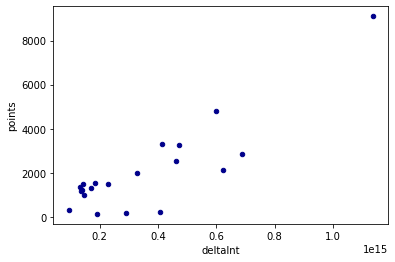

In [102]:
# Find the number of points per tract and the Time Delta as an int for graphing
dfPtsDelt = pd.DataFrame()

# Create new row for points within the td
for index, row in dfTrackDayPlus.iterrows():
    points = len(df.loc[df['track'] == index])
    dfPtsDelt.loc[index,'points'] = int(points)

# Convert td into an int
dfPtsDelt['deltaInt'] = dfTrackDayPlus['delta'].astype(int)

# Graph points by time delta to see if there are many points that fall outside the standard deviation
ax1 = dfPtsDelt.plot.scatter(x='deltaInt', y='points', c='DarkBlue')
dfPtsDelt.describe()

In [ ]:



# Figure out the mean/std deviation of time differences

# Determine which tracks have overnight time

# In the ones that have overnight time, figure out how many repeat points there are at the end of the track

# Make new column - time after previous track

# Figure out if the tracks are within the same day or not.

# Figure out which days are missing tracks

In [ ]:
trackTimes = {'longer': [],
              'shorter': []
             }


In [ ]:
# find out if the end of the track has many grouped items




In [ ]:
dfMultiTZ['states'][3]

In [ ]:
# Group states by country code
# https://stackoverflow.com/questions/48979604/pandas-for-each-unique-value-in-one-column-get-unique-values-in-another-column


dfMultiTZ.merge(statesByCountry, left_index=True, right_index=True)

# for code in statesByCountry:
#     print(code.index())
#     if statesByCountry in dfMultiTZ['code']:
#         print(statesByCountry)

In [ ]:
# type(df['time'][0])
df['time'][0].to_pydatetime()

In [ ]:
# df['time'] = pd.to_datetime(df['time'])
# df['time']

import datetime as dt
# readable = datetime.datetime.fromtimestamp().isoformat()
# print(readable)

startdate = dt.datetime.combine(df['time'][0].date(), df['time'][0].time())
for t in df['time']:
    print(t.tzinfo)

In [ ]:
# Create new DF of values that need to be tracked
dfValues = df[['track','time','alt','lat','long']].copy()
dfValues

In [ ]:
# Find difference between trailing rows
dfDiff = dfValues.diff()
dfDiff.head()

In [ ]:
dfValues = dfValues.diff()

In [ ]:
# Create new Df with only values that need to be differentiated
dfValues = df[['track','alt','lat','long']].copy()
dfValues.dtypes

In [ ]:
type(df['time'][0])

In [ ]:
old[['A', 'C', 'D']].copy()

In [ ]:
# Merge Address DF with original DF
dfFinal = df.merge(dfAddress, left_index=True, right_index=True)


In [ ]:

dfTimeSortedDiff = dfTimeSorted.diff()
dfTimeSortedDiff.head()

In [ ]:
# Merge DFs and rename columns
dff = dfTimeSorted.merge(dfTimeSortedDiff, left_index=True, right_index=True)
dff.columns = ['TrackNo','Time', 'Latitude', 'Longitude','Elevation','NewTrack','TimeDiff','LatitudeDiff', 'LongitudeDiff', 'ElevationDiff']
dff['NewTrack'] = dff['NewTrack'].fillna(1).astype(int)
dff.head()

In [ ]:
dff.loc[(dff['LatitudeDiff'] < 0.0009) & (dff['LatitudeDiff'] > -0.0009) & (dff['LongitudeDiff'] < 0.0009) & (dff['LongitudeDiff'] > -0.0009)]

In [ ]:
dff['NewTrack'] = dff['NewTrack'].map({'0': 'NaN'})

In [ ]:
# Search for the coordinates and unpack resulting address dictionary
addy = json.loads(json.dumps(rg.search(coordAU)[0]))

In [ ]:
# take min and max of tract and see if it is more than 1 day

# break down walking vs. transportation

# smaller clusters of walking stops or transportation stops